# Using MELD for analysis of two conditions with replicates
## Introduction

This quickstart tutorial uses a preprocessed dataset from [Wagner et al. (2018) (doi: 10.1126/science.aar4362)](https://www.ncbi.nlm.nih.gov/pubmed/29700229). 

MELD is an algorithm for density estimation on graphs. You can quantify the effect of an experimental perturbation by comparing the relative density of various conditions. In regions of the graph with the same density across conditions, there is no effect of the perturbation. In regions with higher density in a treatment condition relative to a control, it can be concluded that the perturbation leads to an enrichment of those cell types.

We'll first focus on analysis of two conditions, _chd_ (treatment) and _tyr_ (control) collected in triplicate (samples A-C).

#### Installing packages

We need the following packages to run MELD

In [ ]:
!pip install --user meld phate scanpy

#### Loading data

This data was previously preprocessed and a dimensionality reduced representation has been calculated using PHATE. For recommendations on scRNA-seq preprocesing, please consult [best practices](https://www.embopress.org/doi/10.15252/msb.20188746).

We're doing to download the data from figshare and get started!

**Standard imports**


In [4]:
import os
import pandas as pd
import numpy as np
import scprep
import meld

# making sure plots & clusters are reproducible
np.random.seed(42)

%load_ext autoreload
%autoreload 2

import scanpy as sc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
download_path = os.path.expanduser("~")
download_path = os.path.join(download_path,'Wagner2018.processed.h5ad')

URL = 'https://ndownloader.figshare.com/files/25687247?private_link=f194ae7d6bcec9bd11a3'
scprep.io.download.download_url(URL, download_path)

In [7]:
adata = sc.read_h5ad(download_path)

#### Plotting the number of cells in each sample



In [9]:
sample_cmap = {'chdA' : '#fb6a4a',
                'chdB' : '#de2d26',
                'chdC' : '#a50f15',
                'tyrA' : '#6baed6',
                'tyrB' : '#3182bd',
                'tyrC' : '#08519c'}

As we can see in the following plot, there are many more cells in the chdA sample relative to the other samples. To account for this, the MELD algorithm normalizes the density of each replicate to account for varying numbers of cells.



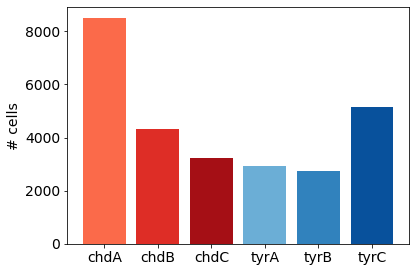

In [10]:
fig, ax = plt.subplots(1)

groups, counts = np.unique(adata.obs['sample_labels'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c, color=sample_cmap[groups[i]])
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()

#### Running MELD

These commands run the MELD algorithm. In our full length tutorial, we provide guidance on parameter selection tuned for a specific dataset. **We recommend parameter tuning for best results**. However, in the interest of expediency, we'll use default parameters here.

In [13]:
meld_op = meld.MELD()
sample_densities = meld_op.fit_transform(adata, sample_labels=adata.obs['sample_labels'])

Building graph on 26827 samples and 29197 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 13.76 seconds.
  Calculating KNN search...
  Calculated KNN search in 71.61 seconds.
  Calculating affinities...
  Calculated affinities in 2.93 seconds.
Calculated graph and diffusion operator in 89.89 seconds.


#### Plotting sample density

These plots show the output of the MELD operator: the **sample-associated density estimate**\*. This density estimate is the [Kernel Density Estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) of each sample over the graph. Here the density at each point is between 0 and 0.00015, and the total density for each sample sums to 1.

\*We avoid the use of the phrase "sample density" because the graph that we're using 

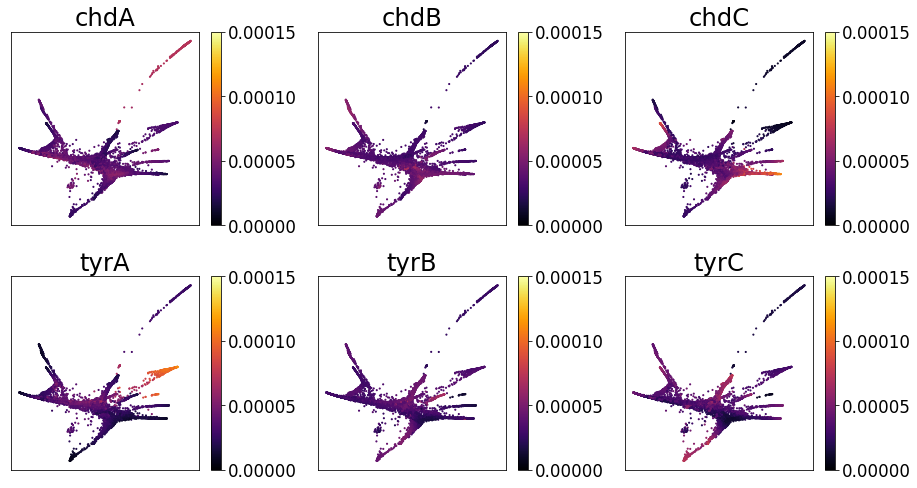

In [17]:
fig, axes = plt.subplots(2,3, figsize=(13,7))

for i, sample in enumerate(np.unique(sample_densities.columns)):
    ax = axes.flatten()[i]
    scprep.plot.scatter2d(adata.obsm['X_PHATE'], title=sample,
                          c=sample_densities[sample], cmap='inferno', 
                          vmin=0, vmax=0.00015, ax=ax, ticks=False)
    
fig.tight_layout()

#### Calculate likelihood of each _chd_ sample relative to the matched _tyr_ sample

MELD is based on a [manifold model](https://doi.org/10.1016/j.coisb.2017.12.008) of biology where the underlying state space is continuous and locally Euclidean. The output of the MELD operator is a kernel density estimate. 

When examined across all cells in the dataset, these densities represent the probability of the data given the condition. In other words, the density estimate answers the question, "If I collect cells in condition X, what is the probability of observing each cell?"

However, we can also consider the different density estimates for each of the 6 samples calculated for each cell. In this context, the output of the MELD operator estimates the _likelihood_ of the sample label given the data. We then calculate the relative likelihood of each matched treatment and control sample to quantify the effect of the perturbation.

#### What if I have multiple treatment conditions?

Note, here we only have one treatment condition (_chd_), but we can easily extent this to multiple treatment conditions as we'll show below.

In [19]:
chd_likelihoods = []
for replicate in 'ABC':
    # Calculate the ratio of sample densities across matched treatment and control samples 
    # (e.g. chdA vs tyrA)
    chd_likelihoods.append(
        meld.normalize_densities(
            sample_densities[['chd{}'.format(replicate),'tyr{}'.format(replicate)]]
        )
    )

# Only need to keep the likelihood of the chd conditions
chd_likelihoods = pd.concat(chd_likelihoods, axis=1)[['chdA', 'chdB', 'chdC']] 

#### Plot the _chd_ likelihoods

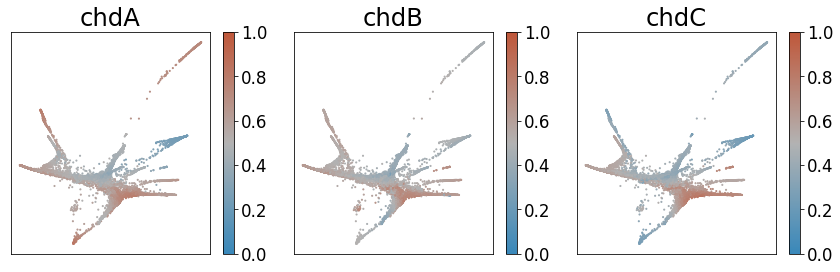

In [20]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

for i, sample in enumerate(chd_likelihoods.columns):
    ax = axes.flatten()[i]
    scprep.plot.scatter2d(adata.obsm['X_PHATE'], title=sample,
                          c=chd_likelihoods[sample], cmap=meld.get_meld_cmap(),
                          vmin=0, vmax=1,
                          ax=ax, ticks=False)
    
fig.tight_layout()

In the above plots, the output of the MELD operator is the relative likleihood of observing each cell in the _chd_ treatment condition relative to the matched _tyr_ control.

Two questions that we might consider are:
1. For each cell, how likely _on average_ are we to see that cell in the _chd_ condition relative to the control?
2. What is the _variation_ in relative likelihood? Are there some cells that are more consistently enriched/depleted/unaffected?

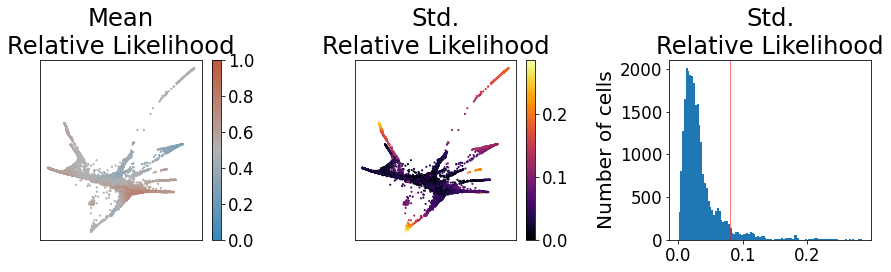

In [27]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

scprep.plot.scatter2d(adata.obsm['X_PHATE'], title='Mean\nRelative Likelihood',
                      c=chd_likelihoods.mean(axis=1), cmap=meld.get_meld_cmap(),
                      vmin=0, vmax=1, ax=axes[0], ticks=False)

scprep.plot.scatter2d(adata.obsm['X_PHATE'], title='Std.\nRelative Likelihood',
                      c=chd_likelihoods.std(axis=1), cmap='inferno',
                      vmin=0, ax=axes[1], ticks=False)

scprep.plot.histogram(chd_likelihoods.std(axis=1), title='Std.\nRelative Likelihood',
                      ax=axes[2])
axes[2].axvline(0.08, color='r', linewidth=0.5)

fig.tight_layout()

The first plot here answers our first question about the average relative likelihood across replicates. We will refer to this value as the _chd_ relative likelihood for downstream analysis in the next sections. 

The second two plots give us an estimate of the variation in this estimate. We will touch upon how to use those estimates later.

### Calculate likelihood of the replicate for the chd and tyr conditions independently

In [ ]:
replicate_likelihoods = [meld.normalize_densities(sample_densities[['chdA', 'chdB', 'chdC']]),
                         meld.normalize_densities(sample_densities[['tyrA', 'tyrB', 'tyrC']])]
replicate_likelihoods = pd.concat(replicate_likelihoods, axis=1)

In [ ]:
replicate_likelihoods

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(12,8))

for i, sample in enumerate('ABC'):
    ax = axes.flatten()[i]
    if i < 3:
        batch = 'tyr'
    else:
        batch = 'chd'
    if i % 3 == 0:
        ylabel = batch
    else:
        ylabel = None
    scprep.plot.scatter2d(adata.obsm['X_PHATE'], title=sample, ylabel=ylabel,
                          c=replicate_likelihoods['{}{}'.format(batch, sample)], cmap='inferno',
                          vmin=0, vmax=1,
                          ax=ax, ticks=False)

fig.tight_layout()

## 3. Embedding Data Using PHATE

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.


Here's the simplest way to apply PHATE:
```python
phateop = phate.PHATE(knn=9, decay=10, gamma=0, n_jobs=-2)
Y = phateop.fit_transform(data_sq)
```

In [ ]:
data_pca = scprep.reduce.pca(data_sqrt)

phate_op = phate.PHATE(knn=10, decay=10, n_jobs=-1)
data_phate = phate_op.fit_transform(data_pca)

### Coloring a PHATE plot by sample ID

And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

In [ ]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], cmap=sample_cmap, 
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

### Coloring a PHATE plot by ClusterIDs

In Wagner et al. (2018), cells from the *chd* and *tyr* conditions were assigned cluster IDs through projection back to a reference dataset. In the published analysis, these number of cells mapping to each cluster in the *chd* vs *tyr* condition was used at the measure of *chd* loss-of-function on that cluster. To visualize the relationships between these clusters, we will color the PHATE plot by each cell's published ClusterID.

In [ ]:
scprep.plot.scatter2d(data_phate, c=metadata['cluster'], cmap=cmocean.cm.phase, 
                      legend_anchor=(1,1), figsize=(5,5), s=10, label_prefix='PHATE', ticks=False)

### Interpreting the PHATE plot

Examining this PHATE plot, we see observe a complex many-branched structure. We can see that each region or branch of the PHATE plot is enriched for various clusters. However, you may notice that there are some clusters that occupy several branches of the plot. This is one of the issues with clustering - it is not perfect and the diversity within each cluster may not be uniform across clusters.

## 4. Using MELD to calculate sample-associated density estimates and relative likelihood

Using MELD, we quantify the effect of an experimental perturbation by first estimating the density of each sample over a graph learned from all cells from all samples. This yields one density estimate per sample. We then normalize density estimates across samples from the same replicate to calculate the sample-associated relative likelihood. This relative likelihood is a ratio between the sample probability densities from each condition and indicates how much more likely we are to observe a given cell in one condition relative to another. 

We can use the relative likelihood estimates to identify which cells are the most enriched in each experimental condition and which cell types are unchanging across conditions. We can also use this value to identify the gene signature of a perturbation (*i.e.* the genes that change the most across experimental conditions).

#### Separating replicate and conditions

We run the MELD algorithm on each sample independently, then normalize within each replicate. First we're going to create a vector that indicated the replicate that each cell was sequenced in.

In [ ]:
metadata['genotype'] = [1 if sl.startswith('chd') else 0 for sl in metadata['sample_labels']]
metadata['genotype_name'] = ['chd' if g == 1 else 'tyr' for g in metadata['genotype']]
metadata['replicate'] = [sl[-1] for sl in metadata['sample_labels']]

### (Optional) Parameter search

As noted in our manuscript, the optimal filter and graph parameters for the MELD algorithm can vary with dataset size and structure. To select parameters automatically, we added a framework to generate many random signals over a dataset and calculate the accuracy of the MELD algorithm with different graph and filter parameters.

The base unit of this parameter search is the `meld.Benchmarker()` class. The basic workflow of the benchmarker class is as follows:

1. Generate a random conditional density over the data (PDF)
2. Randomly assign cells to an `expt` and `ctrl` condition based on the PDF
3. Run the MELD algorithm on the data using user-specific parameters
4. Calculate the Mean Square Error (MSE) between the sample-associated relative likelihood for the `expt` condition and the ground-truth PDF

We then repeat these steps a number of times for each set of parameters and compare the MSE of the outputs. The lowest average MSE is the optimal set of parameters for downstream analysis.

In [ ]:
benchmarker = meld.Benchmarker()

# 3D PHATE components are used to create the ground truth PDF
benchmarker.fit_phate(data_pca);

Let's plot three random PDFs

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

for i, ax in enumerate(axes):
    benchmarker.generate_ground_truth_pdf()
    scprep.plot.scatter2d(data_phate, c=benchmarker.pdf, cmap=meld.utils.get_meld_cmap(),
                     vmin=0, vmax=1, ticks=False, ax=ax)
    
fig.tight_layout()

Next, we import a library to run the parameter search in parallel. I'm writing this tutorial on a server with 36 cores and I'd like to use them! If you haven't used joblib before, it's a really handy library for taking `for` loops and turning them into parallel operations. Read more: https://joblib.readthedocs.io/en/latest/

Note, the following parameter search takes more than 12 hours on a 36 core server. You could speed up the process by running a more coarse grained parameter search (set the `step` parameter in the `np.arange` calls below) and then run a more fine tuned search once you've narrowed the set of parameters that have the best performance.

For the purposed of this tutorial, you can also just load the results of the parameter search by skipping the to "Loading Parameter Search Results" code block.

In [ ]:
from joblib import Parallel, delayed

def simulate_pdf_calculate_likelihood(benchmarker, seed, beta):
    benchmarker.set_seed(seed)
    benchmarker.generate_ground_truth_pdf()
    
    benchmarker.generate_sample_labels()
    benchmarker.calculate_MELD_likelihood(beta=beta)
    MELD_mse = benchmarker.calculate_mse(benchmarker.expt_likelihood)
    return MELD_mse, seed, beta, benchmarker.graph.knn

In [ ]:
knn_range = np.arange(1,25)
beta_range = np.arange(1,200)

In [ ]:
results = []

with Parallel(n_jobs=36) as p:
    for knn in knn_range:
        # doing this outside the parallel loop because building the graph takes the longest
        benchmarker.fit_graph(adata.X, knn=knn)
        print(knn)
        curr_results = p(delayed(simulate_pdf_calculate_likelihood)(benchmarker, seed, beta) \
                                       for seed in range(25) for beta in beta_range)
        curr_results = pd.DataFrame(curr_results, columns = ['MSE', 'seed', 'beta', 'knn'])
        results.append(curr_mse)

results = pd.concat(results, axis=0)

### Loading Parameter Search Results

Since the above code takes a long time to run, we can also download the results.

In [ ]:
import os, tempfile

URL = 'https://github.com/KrishnaswamyLab/MELD/blob/master/data/Klein_parameter_search_results.pickle.gz?raw=true'

with tempfile.TemporaryDirectory() as tempdir:
        filepath = os.path.join(tempdir, "parameter_search_results.pickle.gz")
        scprep.io.download.download_url(URL, filepath)
        results = pd.read_pickle(filepath)

# We want to take the average of each set of random seeds for each combination of beta and knn values
results_wide = results.groupby(['beta', 'knn']).mean().sort_values(by='MSE').reset_index()

We can use a scatterplot to visualize the results of the parameter search. Here, brighter colors are mapped to lower Mean Squared Error and thus correspond to higher accuracy.

In [ ]:
ax = scprep.plot.scatter(results_wide['beta'], results_wide['knn'], 
                         s=50, c=results_wide['MSE'], vmax=0.006, cmap='inferno_r')

# Highlight the top performing combination with a large red dot
top_result = results_wide.sort_values('MSE').iloc[0]
ax.scatter(top_result['beta'], top_result['knn'], c='r', s=100, linewidth=1, edgecolor='k')

This is the best set of parameters on average.

In [ ]:
top_result

Based on the above plots, we can see that the optimal results are achieved with `knn=7` and `beta=67`.

Next, we normalize the densities for each sample to calculate the likelihood of the chordin condition per replicate

In [ ]:
def replicate_normalize_densities(sample_densities, replicate):
    replicates = np.unique(replicate)
    sample_likelihoods = sample_densities.copy()
    for rep in replicates:
        curr_cols = sample_densities.columns[[col.endswith(rep) for col in sample_densities.columns]]
        sample_likelihoods[curr_cols] = sklearn.preprocessing.normalize(sample_densities[curr_cols], norm='l1')
    return sample_likelihoods

In [ ]:
sample_likelihoods = replicate_normalize_densities(sample_densities, metadata['replicate'])

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(13,4))

experimental_samples = ['chdA', 'chdB', 'chdC']

for i, ax in enumerate(axes):
    curr_sample = experimental_samples[i]
    scprep.plot.scatter2d(data_phate, c=sample_likelihoods[curr_sample], cmap=meld.get_meld_cmap(),
                          vmin=0, vmax=1,
                          title=curr_sample, ticks=False, ax=ax)

fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8.7,4))

scprep.plot.scatter2d(data_phate, c=sample_likelihoods[experimental_samples].mean(axis=1), 
                      cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                      title='Mean', ticks=False, ax=axes[0])
scprep.plot.scatter2d(data_phate, c=sample_likelihoods[experimental_samples].std(axis=1), vmin=0, 
                      cmap='inferno', title='St. Dev.', ticks=False, ax=axes[1])

fig.tight_layout()

We use the average likelihood of the chordin samples as the measure of the perturbation.

In [ ]:
metadata['chd_likelihood'] = sample_likelihoods[experimental_samples].mean(axis=1).values

### Examining the distribution of _chd_ likelihood values in published clusters

In [ ]:
sample_cmap = {'chdA': '#fb6a4a',
                 'chdB': '#de2d26',
                 'chdC': '#a50f15',
                 'tyrA': '#6baed6',
                 'tyrB': '#3182bd',
                 'tyrC': '#08519c'}



Let's sort the index of each cluster from lowest to highest average _chd_ likelihood value

In [ ]:
metadata['clusterID'] = scprep.utils.sort_clusters_by_values(metadata['clusterID'], metadata['chd_likelihood'])

#### Create jitter plots

These show the distribution of _chd_ likelihood values within each cluster. Each point is a cell and the y-axis is the _chd_ likelihood. The slight jitter in the x-xais is  only to help show density within each cluster.

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

# See example usage: https://scprep.readthedocs.io/en/stable/examples/jitter.html
scprep.plot.jitter(metadata['clusterID'], metadata['chd_likelihood'], c=metadata['sample_labels'], 
                   cmap=sample_cmap,legend=False, plot_means=False, xlabel=False, ylabel='Mean chd likelihood',
                   ax=ax)

### This code will plot the ratio of tyr:chd cells per cluster
means = metadata.groupby('clusterID')['genotype'].mean()
ax.scatter(means.index, means - np.mean(metadata['genotype']) + 0.5, color='#e0d8f0', edgecolor='k', s=100)

# Axis tick labels
ax.set_xticklabels(metadata.set_index('clusterID')['cluster'].drop_duplicates().sort_index(), rotation=90)
ax.set_ylim(0,1)

fig.tight_layout()

####  Interpreting the plot

Here, we can see the distribution of _chd_ likelihood values for each cell organized by the clusterID assigned by Wagner et al. (2018). Due to the issues with clustering above, we see that some clusters contain "outliers." For example, in the cluster on the far left, "optic primordium", has an average _chd_ likelihood value of around -0.28, indicating that these cells are generally more prototypical in the tyrosinase condition. This is consisten with the observed reduced head size in *chd* mutant zebrafish (See Wanger et al. 2018 for a thorough description of the mutant phenotype). However, there are also some cells with very high _chd_ likelihood values, and a couple with values around 0.55. This is a result of the clustering assigning the same cluster label to cells that are not adjacent on the cell similarity graph. 

This problem is especially apparent with the `tailbud - spinal cord` and `tailbud - PSM`* populations where the range of _chd_ likelihood values in each group is especially large. In the MELD publication, we focued on the tailbud - presomitic mesoderm population. So let's start there.

\*(PSM = presomitic mesoderm)

## 5. Using VFC to subcluster each published cluster


Here, we're going to select and arbitrary cutoff that we only want to consider clusters that have at least 1% of the data for further clustering. For this dataset, that means we'd consider clusters with >268 cells.

In [ ]:
# Get cluster indicides and number of cells per cluster
clusters, counts = np.unique(metadata['clusterID'], return_counts=True)

# Keep cluster labels with at least 1% of the data
clusters = clusters[counts > data.shape[0] * 0.01]

#### Visualize each cluster using PHATE

Here, we want to visualize the heterogeneity within each cluster using PHATE run on each dataset. If the PHATE embedding shows multiple groups of cells with different _chd_ likelihood values (as in cluster 26, for example) we can reason that this cluster might need further subsclustering using VFC.

In [ ]:
data_cluster_phate = {}

for cluster in clusters:
    curr_data = data_pca.loc[metadata['clusterID'] == cluster]
    data_cluster_phate[cluster] = phate.PHATE(verbose=0).fit_transform(curr_data)

In [ ]:
fig,axes= plt.subplots(5,4, figsize=(4*3, 5*3))

for i , ax in enumerate(axes.flatten()):
    if not i < len(clusters):
        ax.axis('off')
        continue
    curr_cluster = clusters[i]
    curr_phate = data_cluster_phate[curr_cluster]
    
    scprep.plot.scatter2d(curr_phate, 
                          c=metadata['chd_likelihood'].loc[metadata['clusterID'] == curr_cluster], 
                          cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                         ax=ax, ticks=False, 
                          title='Cluster {} ({})'.format(curr_cluster, curr_phate.shape[0]), 
                          legend=False, fontsize=10)

#### Build a VFC operator for each cluster

Next, we want to examine the differences between the results of VFC clustering at different numbers of clusters. The goal here is to make sure that the results of the clustering align with the grouping of cells we observe in the PHATE plots and the distribution of likelihood values.

In [ ]:
np.random.seed(0)
vfc_op_per_cluster = {}

for cluster in np.unique(metadata['clusterID']):
    curr_G = gt.Graph(data_pca.loc[metadata['clusterID'] == cluster], use_pygsp=True)
    curr_G.compute_fourier_basis()
    curr_sample_labels = metadata['genotype'].loc[metadata['clusterID'] == cluster]
    curr_likelihood = metadata['chd_likelihood'].loc[metadata['clusterID'] == cluster]
    curr_vfc = meld.VertexFrequencyCluster(n_clusters = 3)
    curr_vfc.fit_transform(curr_G, curr_sample_labels, curr_likelihood)
    vfc_op_per_cluster[cluster] = curr_vfc

In [ ]:
subclustering_results = {}
for cluster in np.unique(metadata['clusterID']):
    curr_vfc = vfc_op_per_cluster[cluster]
    clusters_by_n = {}
    for n in [2,3,4,5]:
        clusters_by_n[n] = curr_vfc.predict(n)
    subclustering_results[cluster] = clusters_by_n

I've already looked through the clusters and determined which number of clusters look best to me. The results are stored in the following dictionary

In [ ]:
picked_clusters = {
    4:3,  8:3, 15:3, 17:2, 18:3, 
    22:3, 24:3, 25:3, 26:4, 27:5}

Now we're going to plot the results of all of the VFC clustering results. This produces a very long figure, but it's worth looking at each of the plots individually. We don't claim that the cluster values we selected are "correct" because there's no clear objective we're targeting here. Take cluster 11, for example. Perhaps we should have looked at 5 clusters here to more closely match the structure observed in the embedding. To dive more deeply, one could perform differential expression testing between the 5 clusters to see if the heterogeneity in the visualization is biologically relevant.

The red boxes indicate the clustering that we selected.

In [ ]:
fig, axes= plt.subplots(19,5, figsize=(15, 19*3))

for i, r_ax in enumerate(axes):
    cluster = clusters[i]
    curr_phate = data_cluster_phate[cluster]

    for i, n in enumerate([0,2,3,4,5]):
        if i == 0:
            cvec = metadata['chd_likelihood'].loc[metadata['clusterID'] == cluster]
            ylabel= str(cluster) + ' ({})'.format(len(cvec))

            cmap= meld.get_meld_cmap()
            vmin=0
            vmax=1           
        else:
            cvec = subclustering_results[cluster][n]
            cmap = ylabel = vmin = vmax = None
            
        if np.sum(metadata['clusterID'] == cluster) < (metadata.shape[0] * 0.01):
            plt.setp(r_ax[i].spines.values(), color='lightgrey', linewidth=4)
        scprep.plot.scatter2d(curr_phate, c=cvec, cmap=cmap, vmin=vmin, vmax=vmax,
                         ax=r_ax[i], ticks=False, ylabel=ylabel, fontsize=8, legend=False)
        # Red outline for clusters that we decide to subcluster
        if cluster in picked_clusters:
            if picked_clusters[cluster] == n:
                plt.setp(r_ax[i].spines.values(), color='r', linewidth=4)

Now let's actually break up the clusters using the VFC results and create a new jitter plot.

In [ ]:
metadata['VFC'] = metadata['clusterID'].copy()
for curr_cluster in clusters:
    if curr_cluster not in picked_clusters:
        continue
    
    new_clusters = subclustering_results[curr_cluster][picked_clusters[curr_cluster]]
    
    metadata.loc[metadata['clusterID'] == curr_cluster, 'VFC'] = new_clusters + 1 + np.max(metadata['VFC'])
metadata['VFC'] = scprep.utils.sort_clusters_by_values(metadata['VFC'], metadata['chd_likelihood'])

In [ ]:
ax = scprep.plot.jitter(metadata['VFC'], metadata['chd_likelihood'], c=metadata['sample_labels'],
                        cmap=sample_cmap, figsize=(18,7), legend=False)
ax.set_ylim(0,1)
ax.axhline(0.5, linestyle = '--', color='grey', zorder=0)

## 6. Isolating the Tailbud - Presomitic Mesoderm cluster

Next, we will create a mask on the data to zero in on the cells corresponding to the `tailbud - presomitic mesoderm` cluster and visualize these cells using PHATE.

### Data denoising using MAGIC

In [ ]:
marker_genes = ['aldh1a2', 'cdx4', 'foxd3', 'fsta', 'gata2a', 'lmo2', 'meox1',
       'myl10', 'myod1', 'myog', 'ntd5', 'ripply1', 'sox2', 'ta', 'tal1',
       'tbx6', 'wnt8a']
data_magic = magic.MAGIC().fit_transform(data, genes=marker_genes)

In [ ]:
# Subset data from this cluster
curr_cluster = 26
curr_cluster_data = data.loc[np.isin(metadata['clusterID'], curr_cluster)].copy()
curr_cluster_data_magic = data_magic.loc[np.isin(metadata['clusterID'], curr_cluster)].copy()
curr_cluster_metadata = metadata.loc[np.isin(metadata['clusterID'], curr_cluster)].copy()
curr_data_phate = data_cluster_phate[curr_cluster]

### Plotting the TPM cluster using PHATE

In [ ]:
scprep.plot.scatter2d(curr_data_phate, c=curr_cluster_metadata['chd_likelihood'], cmap=meld.get_meld_cmap(), 
                      figsize=(6,5), s=5, label_prefix="PHATE", ticks=False)

####  Interpreting the PHATE plot

Looking at this plot, we observe several branching structures in the data, indicating that there are probably multiple cell types within the `tailbud - PSM`. Furthermore, we can see that the likelihood values within these cells are not uniformly distributed on the PHATE plot. In fact, some regions of the plot are enriched for high likelihood values and other are enriched for low values. From this, we can hypothesize that the wide range of likelihoods in the `tailbud - PSM` is due to multiple cell types within this group that each exhibit different responses to *chd* loss-of-function.

### Vertex Frequency Clustering

To handle this problem, we developed a method called **vertex frequency clustering**. The algorithm is described in the MELD manuscript, but the goal of this algorithm is to indentify cells that are both 1) transcriptionally similiar and 2) exhibit uniform responses to the experimental perturbation. The algorithm is implemented in the `meld.VertexFrequencyCluster` class. 

This class works similarly to the `sklearn` clustering classes, and all it needs is the graph `G`, the `sample_labels` and the `chd_likelihood` to create a matrix called the spectrogram. Currently, we use `KMeans` to do clustering on the spectrogram, so you must set `k`. Picking `k` is an imperfect science. We arrived at `k=4` for this dataset after trying several numbers of clusters and inspecting the expression of previously characterized marker genes for tissues in the zebrafish embryo.

Note that we set the random seed here, since `KMeans` does not produce the same output every time.

In [ ]:
scprep.plot.scatter2d(curr_data_phate, c=curr_cluster_metadata['VFC'], 
                      figsize=(5,5), s=5, label_prefix="PHATE", ticks=False)

In [ ]:
scprep.plot.jitter(curr_cluster_metadata['VFC'], curr_cluster_metadata['chd_likelihood'], 
                   c=curr_cluster_metadata['sample_labels'], cmap=sample_cmap,
                  legend_anchor=(1,1))

### Characterizing clusters by marker genes

#### Assigning cluster names

Now that we know what cell type is in each cluster, we can assign labels to each group.

To start, lets load a dataframe of marker genes by tissue we created using the supplementary notes from [Farrell et al. (2018)](https://doi.org/10.1126/science.aar3131).

In [ ]:
gist_url = 'https://gist.githubusercontent.com/dburkhardt/ba7784b0eee9bece76be1719485ea571/' \
           'raw/607fdae74e52ab31a22baf29532072330ac62ba8/farrell_larval_zebrafish_marker_genes.csv'
marker_genes = pd.read_csv(gist_url)
marker_genes['gene'] = [g.lower() for g in marker_genes['gene']]

#### Differential expression within clusters

Next we perform differential expression analysis using [diffxpy](https://github.com/theislab/diffxpy/) to identify genes that differentiate each subcluster.

Perform differential expression for each subcluster vs all other cells in the TPM cluster

In [ ]:
subcluster_marker_genes = {}
# Iterate over VFC subclusters
for curr_subcluster in np.unique(curr_cluster_metadata['VFC']):
    # Create mask for current subcluster
    is_curr_subcluster = curr_cluster_metadata['VFC'] == curr_subcluster
    
    # Rank test comparing each subcluster to all other cells in cluster
    curr_de_results = de.test.two_sample(curr_cluster_data.values, 
                                         gene_names = data.columns, 
                                         grouping=is_curr_subcluster,
                                         test='rank').summary()
    
    # P and Q values may be artificially inflated when subclustering
    # so we keep only top 1% of differentially expressed genes 
    # see https://doi.org/10.1016/j.cels.2019.07.012 for more info
    top_genes = curr_de_results.sort_values('qval').loc[curr_de_results['qval'] < 0.05, 'gene'].values
    
    # Get a list of DE genes that are also marker gene
    curr_marker_genes = []
    for gene in top_genes[:230]:
        if gene in marker_genes['gene'].values:
            curr_marker_genes.append(gene)
    subcluster_marker_genes[curr_subcluster] = curr_marker_genes

This plot shows both the relative expression level (color) and relative differential expression (size of dot) for each cluster and gene. The subtissue annotations on the right side of the plot come from the annotation by Farrell et al. (2018). This makes it easier to annotate each cluster.

In [ ]:
all_markers = np.unique(np.hstack(subcluster_marker_genes.values()))
curr_marker_genes = marker_genes.loc[np.isin(marker_genes['gene'], all_markers), ['subtissue', 'gene']]
curr_marker_map = {}
for subtissue in curr_marker_genes['subtissue'].unique():
    curr_marker_map[subtissue] = curr_marker_genes.loc[curr_marker_genes['subtissue'] == subtissue, 'gene'].values

# Although gata2a and fli1a are not in the farrell list, I saw lmo2 was expressed in this tissue and 
# found other markers of hematopoietic cells in https://doi.org/10.1002/wdev.312
curr_marker_map['Hematopoietic'] = ['lmo2', 'gata2a', 'fli1a']

scprep.plot.marker_plot(data=curr_cluster_data.values,
                        gene_names=curr_cluster_data.columns,
                        clusters=curr_cluster_metadata['VFC'], 
                        markers=curr_marker_map,
                        figsize=(12,8))

Now we can assign labels to each cluster

In [ ]:
tpm_cluster_markers = ['myog', 'foxd1', 'myod1', 'wnt8a', 'gata2a']
max_expression = curr_cluster_data.groupby(curr_cluster_metadata['VFC'])[tpm_cluster_markers].mean().idxmax()

In [ ]:
label_map = {max_expression.loc['myod1'] : 'Adaxial - mature',
             max_expression.loc['myog']  : 'Adaxial - immature',
             max_expression.loc['wnt8a'] : 'Presomitic mesoderm',
             max_expression.loc['gata2a'] : 'Hematopoietic'}
cluster_labels = [label_map[cl] for cl in curr_cluster_metadata['VFC']]
pal = sns.color_palette('PuBu', 6)

cluster_cmap = {label_map[cl]:pal[i+1] for i, cl in enumerate(np.unique(curr_cluster_metadata['VFC']))}

And now we can recreate that plot with the proper labels and colors

In [ ]:
scprep.plot.scatter2d(curr_data_phate, c=cluster_labels, cmap=cluster_cmap,
                      figsize=(8,5), s=5, label_prefix="PHATE", ticks=False, 
                      legend_anchor=(1,1))

### Inspecting expression changes between conditions in the full cluster vs in VFC clusters

One of the advantages of VFC is that it makes it possible to identify clusters that are uniformly affected by the perturbation. This means that we expect differential expression of genes between conditions within VFC clusters to be minimal. Here, we're going to plot a kernel density estimate of MAGIC denoised values for each condition within the full cluster and within VFC clusters.

In [ ]:
fig, axes = plt.subplots(5,2, figsize=(8,6))

# Two important marker genes for adaxial cells (myod1) and presomitic mesoderm cells (tbx6)
genes = ['myod1', 'tbx6']
for j, curr_gene in enumerate(genes):
    col_axes = axes[:,j]
    for i, ax in enumerate(col_axes.flatten()):
        exp = {}
        if i < 4:
            # Plot expression for the VFC clusters
            curr_cluster = np.unique(curr_cluster_metadata['VFC'])[i]
            ylabel = label_map[curr_cluster]
            curr_cluster_mask = curr_cluster_metadata['VFC'] == curr_cluster
            
            for geno_name in ['chd', 'tyr']:
                curr_cond_mask  = curr_cluster_metadata['genotype_name'] == geno_name
                curr_exp_cond = curr_cluster_data_magic.loc[(curr_cluster_mask) & (curr_cond_mask), curr_gene]
                
                exp[geno_name] = curr_exp_cond
                color = sample_cmap[geno_name + 'C']
                
                sns.kdeplot(curr_exp_cond, ax=ax, legend=False, color=color, shade=True, clip=[0,5], bw=0.2)
                ax.axvline(np.mean(curr_exp_cond), color=color)
            
        else:
            # Plot expression for the cluster as a whole
            for geno_name in ['chd', 'tyr']:
                ylabel = 'Full cluster'
                curr_exp = curr_cluster_data_magic.loc[curr_cluster_metadata['genotype_name'] == geno_name, curr_gene]
                color = sample_cmap[geno_name + 'C']
                exp[geno_name] = curr_exp_cond
                sns.kdeplot(curr_exp, ax=ax, legend=False, color=color, shade=True, clip=[0,5], bw=0.2)
                ax.axvline(np.mean(curr_exp), color=color)
                
        if j == 0:
            ax.set_ylabel(ylabel, rotation=0, ha='right')
        if i == 0:
            ax.set_title(curr_gene)
            
        lim_map = {'myod1':(-1,5), 'tbx6':(-1,4)}
        ax.set_xlim(lim_map[curr_gene])
        ax.set_yticks([])
        
fig.tight_layout(h_pad=.1, w_pad=.1)


#### Interpreting this plot

Here, we can see that the wide range of _chd_ likelihood values in the `tailbud - PSM` tissue is due to the presence of multiple cell types with different responses to chordin mutagenesis. In fact, the depletion of the adaxial/myotomal cells (indicated by lower _chd_ likelihood values) in chordin mutants is well documented  as is the expansion of the presomitic and somitic tissues (PMID: [9007232](https://www.ncbi.nlm.nih.gov/pubmed/9007232); [10581032](https://www.ncbi.nlm.nih.gov/pubmed/10581032)).

The main takeaway is that for most of the cases, the differences in expression for these genes is either driven by a change in number of subpopulations that respond uniformly to perturbation (as in Myod1) or that the change is restricted to a set of subclusters (as for tbx6). In both cases, VFC analysis provides deeper insight into the effect of the experimental perturbation.